In [18]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

Load the CSV file to examine its contents

In [ ]:
file_path = './data/Data_Temperatures.csv'
weather_data = pd.read_csv(file_path)

weather_data.head()

,Station Name,Measurement Timestamp,Air Temperature
0,63rd Street Weather Station,01/01/2016 12:00:00 AM,-2.80
1,Oak Street Weather Station,01/01/2016 12:00:00 AM,-2.30
2,Foster Weather Station,01/01/2016 12:00:00 AM,-3.67
3,63rd Street Weather Station,01/01/2016 01:00:00 AM,-3.40
4,Foster Weather Station,01/01/2016 01:00:00 AM,-4.56


Process the data

In [20]:
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.interpolate()

df_pivot.head()

Station Name,63rd Street Weather Station,Foster Weather Station,Oak Street Weather Station
Measurement Timestamp,,,
2016-01-01 00:00:00,-2.8,-3.67,-2.3
2016-01-01 01:00:00,-3.4,-4.56,-3.2
2016-01-01 02:00:00,-4.2,-5.50,-4.0
2016-01-01 03:00:00,-5.1,-6.28,-4.8
2016-01-01 04:00:00,-5.7,-7.00,-5.5


In [21]:
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

for station in station_names:
    for lag in range(1, 8):  # 7 hours lag, it can be changed of course
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

lagged_data = lagged_data.dropna()
lagged_data.head()

,63rd Street Weather Station_lag1,63rd Street Weather Station_lag2,63rd Street Weather Station_lag3,63rd Street Weather Station_lag4,63rd Street Weather Station_lag5,63rd Street Weather Station_lag6,63rd Street Weather Station_lag7,Foster Weather Station_lag1,Foster Weather Station_lag2,Foster Weather Station_lag3,...,Oak Street Weather Station_lag1,Oak Street Weather Station_lag2,Oak Street Weather Station_lag3,Oak Street Weather Station_lag4,Oak Street Weather Station_lag5,Oak Street Weather Station_lag6,Oak Street Weather Station_lag7,target_63rd Street Weather Station,target_Foster Weather Station,target_Oak Street Weather Station
Measurement Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07:00:00,-5.8,-6.3,-5.7,-5.1,-4.2,-3.4,-2.8,-6.39,-7.06,-7.00,...,-5.2,-5.8,-5.5,-4.8,-4.0,-3.2,-2.3,-5.1,-5.67,-4.6
2016-01-01 08:00:00,-5.1,-5.8,-6.3,-5.7,-5.1,-4.2,-3.4,-5.67,-6.39,-7.06,...,-4.6,-5.2,-5.8,-5.5,-4.8,-4.0,-3.2,-4.3,-5.06,-3.8
2016-01-01 09:00:00,-4.3,-5.1,-5.8,-6.3,-5.7,-5.1,-4.2,-5.06,-5.67,-6.39,...,-3.8,-4.6,-5.2,-5.8,-5.5,-4.8,-4.0,-3.7,-4.39,-3.3
2016-01-01 10:00:00,-3.7,-4.3,-5.1,-5.8,-6.3,-5.7,-5.1,-4.39,-5.06,-5.67,...,-3.3,-3.8,-4.6,-5.2,-5.8,-5.5,-4.8,-3.3,-4.00,-2.7
2016-01-01 11:00:00,-3.3,-3.7,-4.3,-5.1,-5.8,-6.3,-5.7,-4.00,-4.39,-5.06,...,-2.7,-3.3,-3.8,-4.6,-5.2,-5.8,-5.5,-3.1,-3.56,-2.4


Let's play with XGBoost now!

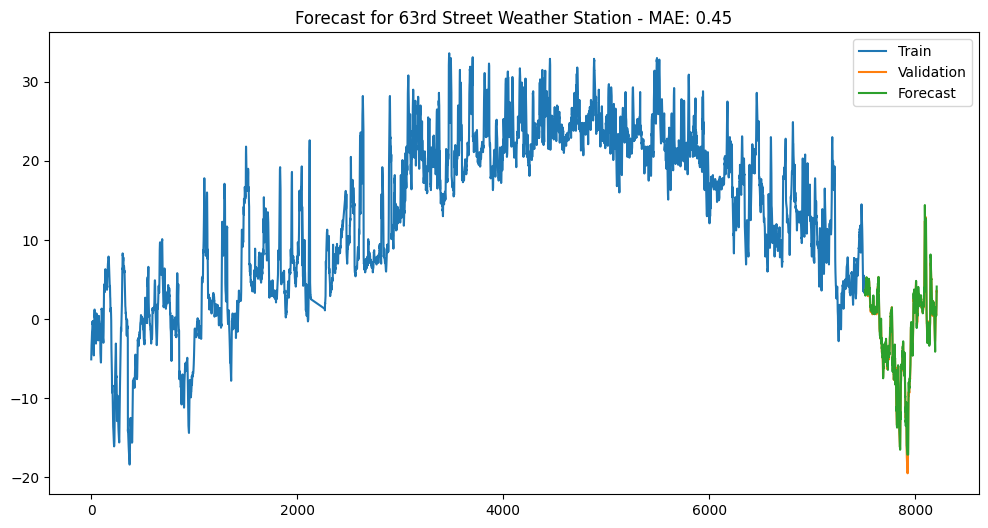

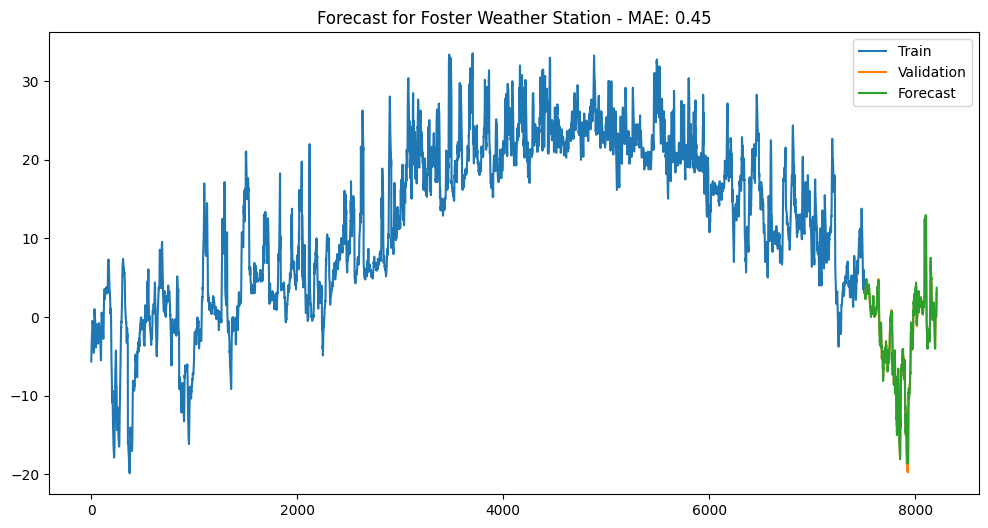

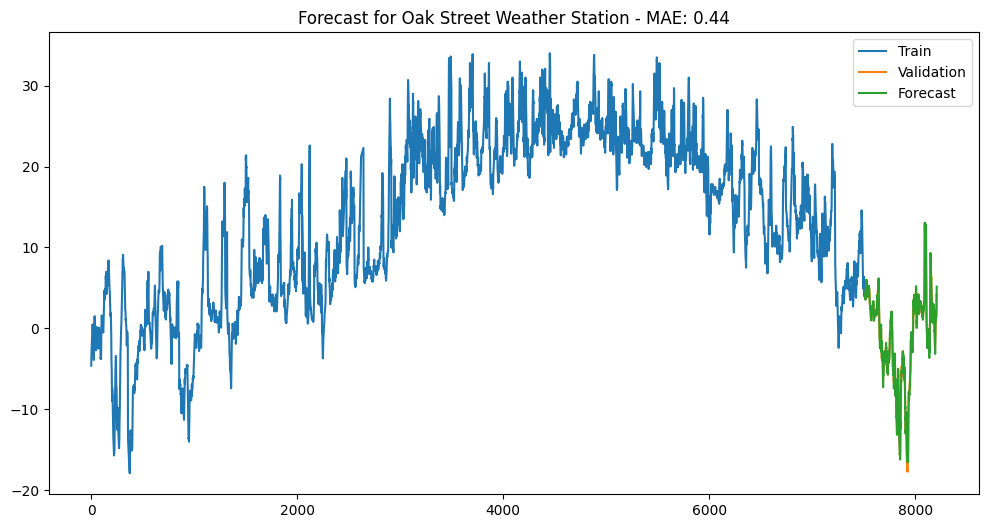

{'63rd Street Weather Station': 0.45447487392124736,
 'Foster Weather Station': 0.44706870900688844,
 'Oak Street Weather Station': 0.44418001349800273}

In [ ]:
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

mae_scores = {}
forecast_results = {}

for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100) # You can tune the hyperparameters here
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mae_scores[station] = mean_absolute_error(y_val, y_pred)

    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.show()

mae_scores

Maybe it's beaten by other models but its speed is incredible!

# Ensemble of XGBoost

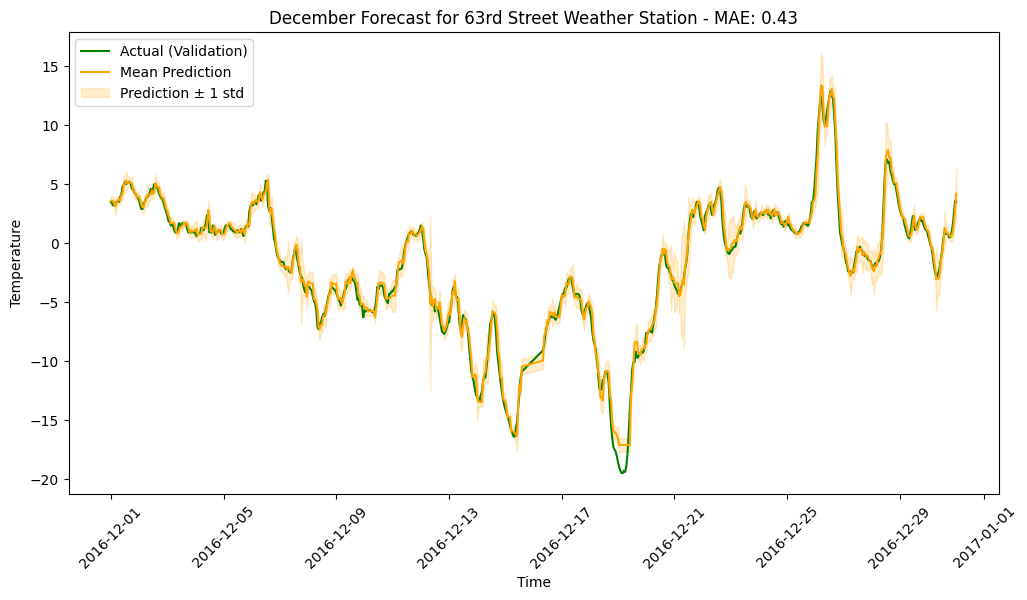

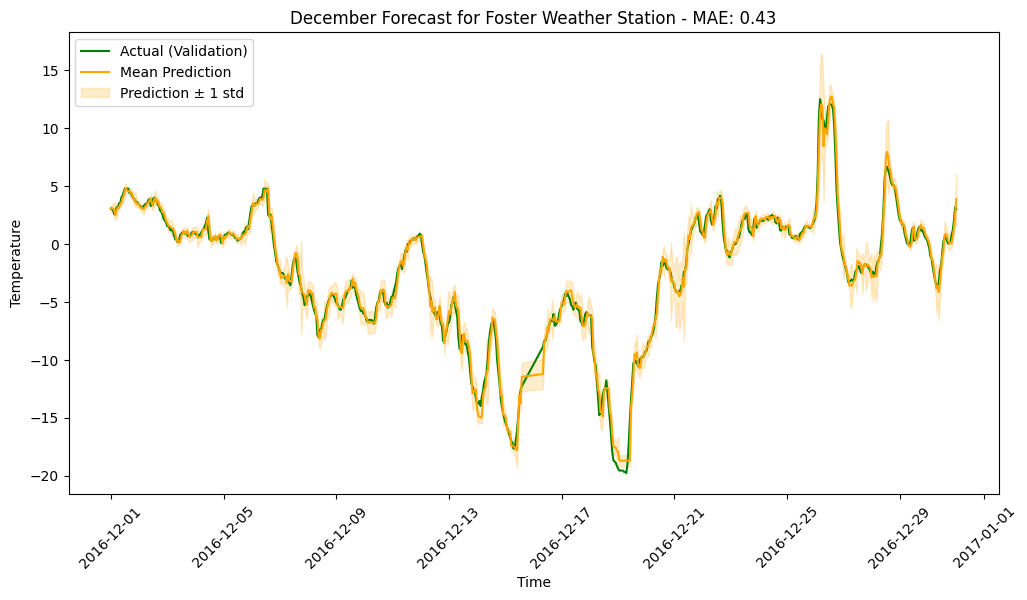

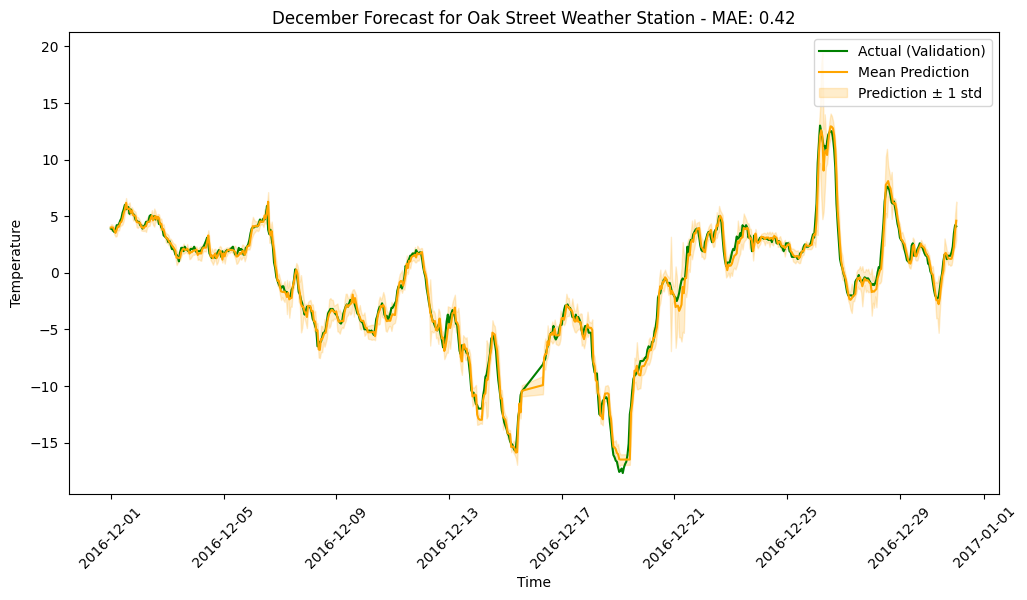

MAE Scores per Station: {'63rd Street Weather Station': 0.4255747043793564, 'Foster Weather Station': 0.42597180343718094, 'Oak Street Weather Station': 0.4224934507957746}


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

file_path = './data/Data_Temperatures.csv'
weather_data = pd.read_csv(file_path)

weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

station_names = df_pivot.columns
lagged_data = pd.DataFrame()

for station in station_names:
    for lag in range(1, 8):  # 7 hours lag
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

lagged_data = lagged_data.dropna()

train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

mae_scores = {}
forecast_results = {}

num_models = 10

for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']
    
    all_predictions = []
    for seed in range(num_models):
        model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, 
                                 subsample=0.8, colsample_bytree=0.8, random_state=seed)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        all_predictions.append(pred)
    
    all_predictions = np.array(all_predictions)
    mean_predictions = np.mean(all_predictions, axis=0)
    std_predictions = 10*np.std(all_predictions, axis=0)

    mae_scores[station] = mean_absolute_error(y_val, mean_predictions)
    
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': mean_predictions,
        'std': std_predictions
    }

for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['validation'].index, results['validation'].values, label="Actual (Validation)", color="green")
    plt.plot(results['validation'].index, results['forecast'], label="Mean Prediction", color="orange")
    plt.fill_between(results['validation'].index, 
                     results['forecast'] - results['std'], 
                     results['forecast'] + results['std'], 
                     color="orange", alpha=0.2, label="Prediction ± 1 std")
    plt.legend()
    plt.title(f"December Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.xticks(rotation=45)
    plt.show()

print("MAE Scores per Station:", mae_scores)
